In [5]:
import torch
from pathlib import Path
import os
from sklearn.metrics import r2_score
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
from Model_simple import *
from Unet_model import *
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
import scipy.stats as st
plt.style.use('default')

In [22]:
# pressure: min=24000000.0 | max=37970486.543
# saturation: min=0.0 | max=0.87943658597

# RMSE through time: extrapolate

### pressure

In [4]:
device = torch.device('cuda')
convlstm = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
convlstm.load_state_dict(torch.load(f'model_weights_10.25-22.21_p@85.pth', map_location=device))    # [notice] match !!
convlstm.eval()
print('done')

unet = UNET(in_channels=4, out_channels=1).float().to(device)
unet.load_state_dict(torch.load('Unet_model_weights_10.12_p.pth', map_location=device))
unet.eval()
print('done')

done
done


In [9]:
def rmse_lstm(case_num):
    min_v = 24e6
    max_v = 37970486.543

    with torch.no_grad():
        x = torch.load(f'tttt_train_p_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        y_arr = y_arr / 1e6

    true = torch.load(f'tttt_train_p_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
    true = true / 1e6

    rmse_list = []
    ssim_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = nrmse(true_tmp, y_tmp, normalization='min-max')
        ssim_v = ssim(true_tmp, y_tmp, data_range=1.0)
        rmse_list.append(rmse_v)
        ssim_list.append(ssim_v)
    return rmse_list, ssim_list


def rmse_u(case_num):
    min_v = 24e6
    max_v = 37970486.543
    
    y_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_p_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            y_arr = y_arr / 1e6
            y_list.append(y_arr)
    y_list = np.stack(y_list, axis=0)
    
    true_list = []
    for tt in range(60):
        true = torch.load(f'ttt_Unet_train_p_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
        true = true / 1e6
        true_list.append(true)
    true_list = np.stack(true_list, axis=0)

    rmse_list = []
    ssim_list = []
    for ii in range(60):
        y_tmp = y_list[ii, :, :]
        true_tmp = true_list[ii, :, :]
        rmse_v = nrmse(true_tmp, y_tmp, normalization='min-max')
        ssim_v = ssim(true_tmp, y_tmp, data_range=1.0)
        rmse_list.append(rmse_v)
        ssim_list.append(ssim_v)
    return rmse_list, ssim_list

# geo test:

def rmse_lstm_geo(case_num):
    min_v = 24e6
    max_v = 37970486.543

    with torch.no_grad():
        x = torch.load(f'geo_train_p_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        y_arr = y_arr / 1e6

    true = torch.load(f'geo_train_p_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
    true = true / 1e6

    rmse_list = []
    ssim_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = nrmse(true_tmp, y_tmp, normalization='min-max')
        ssim_v = ssim(true_tmp, y_tmp, data_range=1.0)
        rmse_list.append(rmse_v)
        ssim_list.append(ssim_v)
    return rmse_list, ssim_list


def rmse_u_geo(case_num):
    min_v = 24e6
    max_v = 37970486.543

    y_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'geo_Unet_train_p_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            y_arr = y_arr / 1e6
            y_list.append(y_arr)
    y_list = np.stack(y_list, axis=0)

    true_list = []
    for tt in range(60):
        true = torch.load(f'geo_Unet_train_p_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
        true = true / 1e6
        true_list.append(true)
    true_list = np.stack(true_list, axis=0)

    rmse_list = []
    ssim_list = []
    for ii in range(60):
        y_tmp = y_list[ii, :, :]
        true_tmp = true_list[ii, :, :]
        rmse_v = nrmse(true_tmp, y_tmp, normalization='min-max')
        ssim_v = ssim(true_tmp, y_tmp, data_range=1.0)
        rmse_list.append(rmse_v)
        ssim_list.append(ssim_v)
    return rmse_list, ssim_list

In [10]:
rmse_lstm_whole = []
rmse_u_whole = []
ssim_lstm_whole = []
ssim_u_whole = []

rmse_lstm_whole_geo = []
rmse_u_whole_geo = []
ssim_lstm_whole_geo = []
ssim_u_whole_geo = []

for cc in np.arange(5000, 5250):
    lstm_rmse, lstm_ssim = rmse_lstm(cc)
    u_rmse, u_ssim = rmse_u(cc)
    rmse_lstm_whole.append(lstm_rmse)
    ssim_lstm_whole.append(lstm_ssim)
    rmse_u_whole.append(u_rmse)
    ssim_u_whole.append(u_ssim)
rmse_lstm_whole = np.stack(rmse_lstm_whole, axis=0)
rmse_u_whole = np.stack(rmse_u_whole, axis=0)
ssim_lstm_whole = np.stack(ssim_lstm_whole, axis=0)
ssim_u_whole = np.stack(ssim_u_whole, axis=0)
print(rmse_lstm_whole.shape, rmse_u_whole.shape, ssim_lstm_whole.shape, ssim_u_whole.shape)

for gg in np.arange(8000, 8250):
    lstm_rmse_geo, lstm_ssim_geo = rmse_lstm_geo(gg)
    u_rmse_geo, u_ssim_geo = rmse_u_geo(gg)
    rmse_lstm_whole_geo.append(lstm_rmse_geo)
    ssim_lstm_whole_geo.append(lstm_ssim_geo)
    rmse_u_whole_geo.append(u_rmse_geo)
    ssim_u_whole_geo.append(u_ssim_geo)
rmse_lstm_whole_geo = np.stack(rmse_lstm_whole_geo, axis=0)
rmse_u_whole_geo = np.stack(rmse_u_whole_geo, axis=0)
ssim_lstm_whole_geo = np.stack(ssim_lstm_whole_geo, axis=0)
ssim_u_whole_geo = np.stack(ssim_u_whole_geo, axis=0)
print(rmse_lstm_whole_geo.shape, rmse_u_whole_geo.shape, ssim_lstm_whole_geo.shape, ssim_u_whole_geo.shape)

(250, 60) (250, 60) (250, 60) (250, 60)
(250, 60) (250, 60) (250, 60) (250, 60)


In [11]:
lstm_mean_list = []
lstm_up_list = []
lstm_low_list = []

u_mean_list = []
u_up_list = []
u_low_list = []

ssim_lstm_mean_list = []
ssim_lstm_up_list = []
ssim_lstm_low_list = []

ssim_u_mean_list = []
ssim_u_up_list = []
ssim_u_low_list = []

# geo test:
lstm_mean_list_geo = []
lstm_up_list_geo = []
lstm_low_list_geo = []

u_mean_list_geo = []
u_up_list_geo = []
u_low_list_geo = []

ssim_lstm_mean_list_geo = []
ssim_lstm_up_list_geo = []
ssim_lstm_low_list_geo = []

ssim_u_mean_list_geo = []
ssim_u_up_list_geo = []
ssim_u_low_list_geo = []

for ttt in range(60):
    lstm_tmp = rmse_lstm_whole[:, ttt]
    u_tmp = rmse_u_whole[:, ttt]
    ssim_lstm_tmp = ssim_lstm_whole[:, ttt]
    ssim_u_tmp = ssim_u_whole[:, ttt]
    # geo--
    lstm_tmp_geo = rmse_lstm_whole_geo[:, ttt]
    u_tmp_geo = rmse_u_whole_geo[:, ttt]
    ssim_lstm_tmp_geo = ssim_lstm_whole_geo[:, ttt]
    ssim_u_tmp_geo = ssim_u_whole_geo[:, ttt]
    
    lstm_low, lstm_up = st.t.interval(0.95, len(lstm_tmp)-1, loc=np.mean(lstm_tmp), scale=st.sem(lstm_tmp))
    lstm_mean = np.mean(lstm_tmp)
    u_low, u_up = st.t.interval(0.95, len(u_tmp)-1, loc=np.mean(u_tmp), scale=st.sem(u_tmp))
    u_mean = np.mean(u_tmp)
    ssim_lstm_low, ssim_lstm_up = st.t.interval(0.95, len(ssim_lstm_tmp)-1, loc=np.mean(ssim_lstm_tmp), scale=st.sem(ssim_lstm_tmp))
    ssim_lstm_mean = np.mean(ssim_lstm_tmp)
    ssim_u_low, ssim_u_up = st.t.interval(0.95, len(ssim_u_tmp)-1, loc=np.mean(ssim_u_tmp), scale=st.sem(ssim_u_tmp))
    ssim_u_mean = np.mean(ssim_u_tmp)
    # geo--
    lstm_low_geo, lstm_up_geo = st.t.interval(0.95, len(lstm_tmp_geo)-1, loc=np.mean(lstm_tmp_geo), scale=st.sem(lstm_tmp_geo))
    lstm_mean_geo = np.mean(lstm_tmp_geo)
    u_low_geo, u_up_geo = st.t.interval(0.95, len(u_tmp_geo)-1, loc=np.mean(u_tmp_geo), scale=st.sem(u_tmp_geo))
    u_mean_geo = np.mean(u_tmp_geo)
    ssim_lstm_low_geo, ssim_lstm_up_geo = st.t.interval(0.95, len(ssim_lstm_tmp_geo)-1, loc=np.mean(ssim_lstm_tmp_geo), scale=st.sem(ssim_lstm_tmp_geo))
    ssim_lstm_mean_geo = np.mean(ssim_lstm_tmp_geo)
    ssim_u_low_geo, ssim_u_up_geo = st.t.interval(0.95, len(ssim_u_tmp_geo)-1, loc=np.mean(ssim_u_tmp_geo), scale=st.sem(ssim_u_tmp_geo))
    ssim_u_mean_geo = np.mean(ssim_u_tmp_geo)
    
    lstm_mean_list.append(lstm_mean)
    lstm_up_list.append(lstm_up)
    lstm_low_list.append(lstm_low)
    u_mean_list.append(u_mean)
    u_up_list.append(u_up)
    u_low_list.append(u_low)
    # geo--
    lstm_mean_list_geo.append(lstm_mean_geo)
    lstm_up_list_geo.append(lstm_up_geo)
    lstm_low_list_geo.append(lstm_low_geo)
    u_mean_list_geo.append(u_mean_geo)
    u_up_list_geo.append(u_up_geo)
    u_low_list_geo.append(u_low_geo)

    ssim_lstm_mean_list.append(ssim_lstm_mean)
    ssim_lstm_up_list.append(ssim_lstm_up)
    ssim_lstm_low_list.append(ssim_lstm_low)
    ssim_u_mean_list.append(ssim_u_mean)
    ssim_u_up_list.append(ssim_u_up)
    ssim_u_low_list.append(ssim_u_low)
    # geo--
    ssim_lstm_mean_list_geo.append(ssim_lstm_mean_geo)
    ssim_lstm_up_list_geo.append(ssim_lstm_up_geo)
    ssim_lstm_low_list_geo.append(ssim_lstm_low_geo)
    ssim_u_mean_list_geo.append(ssim_u_mean_geo)
    ssim_u_up_list_geo.append(ssim_u_up_geo)
    ssim_u_low_list_geo.append(ssim_u_low_geo)

In [69]:
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 4), dpi=1000)
ax = plt.gca()
ax.axvspan(0, 24, facecolor='#FFEECA', alpha=0.3)
ax.axvspan(24, 60, facecolor='#D0E7E5', alpha=0.8)


xx = np.arange(1, 61)
plt.xlim(1, 60)
# plt.ylim(0.5, 1)
plt.plot(xx, u_mean_list, c='mediumblue', label='U-Net (Gaussian)', marker='^', markersize=2, linewidth=0.6, ls='-',)
plt.fill_between(xx, u_low_list, u_up_list, alpha=0.2, color='mediumblue', edgecolor=None)
plt.plot(xx, lstm_mean_list, c='firebrick', label='ED-ConvLSTM (Gaussian)', marker='o', markersize=2, linewidth=0.6, ls='-')
plt.fill_between(xx, lstm_low_list, lstm_up_list, alpha=0.2, color='firebrick', edgecolor=None)
# geo--
plt.plot(xx, u_mean_list_geo, c='blueviolet', label='U-Net (Exponential)', marker='^', markersize=2, linewidth=0.6, ls='--',)
plt.fill_between(xx, u_low_list_geo, u_up_list_geo, alpha=0.2, color='blueviolet', edgecolor=None)
plt.plot(xx, lstm_mean_list_geo, c='salmon', label='ED-ConvLSTM (Exponential)', marker='o', markersize=2, linewidth=0.6, ls='--')
plt.fill_between(xx, lstm_low_list_geo, lstm_up_list_geo, alpha=0.2, color='salmon', edgecolor=None)


# plt.yscale('log')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('month', fontsize=14)
plt.ylabel('NRMSE', fontsize=14)
lgnd = plt.legend(frameon=False, fontsize=10, markerscale=1.5)
# plt.grid(ls=':', lw=0.5, alpha=0.5, which='both', axis='both')

plt.savefig('chutu\\nrmse_extra_pre.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)
plt.close()

In [70]:
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 4), dpi=1000)
ax = plt.gca()
ax.axvspan(0, 24, facecolor='#FFEECA', alpha=0.3)
ax.axvspan(24, 60, facecolor='#D0E7E5', alpha=0.8)


xx = np.arange(1, 61)
plt.xlim(1, 60)
plt.ylim(0.7, 1)
plt.plot(xx, ssim_u_mean_list, c='mediumblue', label='U-Net (Gaussian)', marker='^', markersize=2, linewidth=0.6, ls='-',)
plt.fill_between(xx, ssim_u_low_list, ssim_u_up_list, alpha=0.2, color='mediumblue', edgecolor=None)
plt.plot(xx, ssim_lstm_mean_list, c='firebrick', label='ED-ConvLSTM (Gaussian)', marker='o', markersize=2, linewidth=0.6, ls='-')
plt.fill_between(xx, ssim_lstm_low_list, ssim_lstm_up_list, alpha=0.2, color='firebrick', edgecolor=None)
# geo--
plt.plot(xx, ssim_u_mean_list_geo, c='blueviolet', label='U-Net (Exponential)', marker='^', markersize=2, linewidth=0.6, ls='--',)
plt.fill_between(xx, ssim_u_low_list_geo, ssim_u_up_list_geo, alpha=0.2, color='blueviolet', edgecolor=None)
plt.plot(xx, ssim_lstm_mean_list_geo, c='salmon', label='ED-ConvLSTM (Exponential)', marker='o', markersize=2, linewidth=0.6, ls='--')
plt.fill_between(xx, ssim_lstm_low_list_geo, ssim_lstm_up_list_geo, alpha=0.2, color='salmon', edgecolor=None)


# plt.yscale('log')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('month', fontsize=14)
plt.ylabel('SSIM', fontsize=14)
plt.legend(frameon=False, fontsize=10, markerscale=1.5)
# plt.grid(ls=':', lw=0.5, alpha=0.5, which='both', axis='both')

plt.savefig('chutu\\ssim_extra_pre.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)
plt.close()

### saturation

In [2]:
device = torch.device('cuda')
convlstm_s = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
convlstm_s.load_state_dict(torch.load(f'model_weights_10.30-15.28_s@84.pth', map_location=device))    # [notice] match !!
convlstm_s.eval()
print('done')

unet_s = UNET(in_channels=4, out_channels=1).float().to(device)
unet_s.load_state_dict(torch.load('Unet_model_weights_10.12_s.pth', map_location=device))
unet_s.eval()
print('done')

def rmse_lstm_s(case_num):
    min_v = 0.
    max_v = 0.87943658597

    with torch.no_grad():
        x = torch.load(f'tttt_train_s_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm_s(x.float().unsqueeze(0))
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v

    true = torch.load(f'tttt_train_s_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v

    rmse_list = []
    ssim_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        ssim_v = ssim(true_tmp, y_tmp, data_range=1.0)
        rmse_v = nrmse(true_tmp, y_tmp, normalization='min-max')
        rmse_list.append(rmse_v)
        ssim_list.append(ssim_v)
    return rmse_list, ssim_list


def rmse_u_s(case_num):
    min_v = 0.
    max_v = 0.87943658597

    rmse_list = []
    ssim_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_s_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet_s(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v

            true = torch.load(f'ttt_Unet_train_s_y\\{case_num:>04}_{ts}.pt').squeeze().numpy()    # [64, 64]
            true = true * (max_v - min_v) + min_v
            
            rmse_v = nrmse(true, y_arr, normalization='min-max')
            ssim_v = ssim(true, y_arr, data_range=1.0)
            ssim_list.append(ssim_v)
            rmse_list.append(rmse_v)
    return rmse_list, ssim_list

def rmse_lstm_s_geo(case_num):
    min_v = 0.
    max_v = 0.87943658597

    with torch.no_grad():
        x = torch.load(f'geo_train_s_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm_s(x.float().unsqueeze(0))
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v

    true = torch.load(f'geo_train_s_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v

    rmse_list = []
    ssim_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        ssim_v = ssim(true_tmp, y_tmp, data_range=1.0)
        rmse_v = nrmse(true_tmp, y_tmp, normalization='min-max')
        rmse_list.append(rmse_v)
        ssim_list.append(ssim_v)
    return rmse_list, ssim_list


def rmse_u_s_geo(case_num):
    min_v = 0.
    max_v = 0.87943658597

    rmse_list = []
    ssim_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'geo_Unet_train_s_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet_s(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v

            true = torch.load(f'geo_Unet_train_s_y\\{case_num:>04}_{ts}.pt').squeeze().numpy()    # [64, 64]
            true = true * (max_v - min_v) + min_v

            rmse_v = nrmse(true, y_arr, normalization='min-max')
            ssim_v = ssim(true, y_arr, data_range=1.0)
            ssim_list.append(ssim_v)
            rmse_list.append(rmse_v)
    return rmse_list, ssim_list

done
done


In [3]:
rmse_lstm_whole_s = []
rmse_u_whole_s = []
ssim_lstm_whole_s = []
ssim_u_whole_s = []
# geo--
rmse_lstm_whole_s_geo = []
rmse_u_whole_s_geo = []
ssim_lstm_whole_s_geo = []
ssim_u_whole_s_geo = []

for cc in np.arange(5000, 5250):
    lstm_s, lstm_s_ssim = rmse_lstm_s(cc)
    u_s, u_s_ssim = rmse_u_s(cc)
    rmse_lstm_whole_s.append(lstm_s)
    rmse_u_whole_s.append(u_s)
    ssim_lstm_whole_s.append(lstm_s_ssim)
    ssim_u_whole_s.append(u_s_ssim)
rmse_lstm_whole_s = np.stack(rmse_lstm_whole_s, axis=0)
rmse_u_whole_s = np.stack(rmse_u_whole_s, axis=0)
ssim_lstm_whole_s = np.stack(ssim_lstm_whole_s, axis=0)
ssim_u_whole_s = np.stack(ssim_u_whole_s, axis=0)

print(rmse_lstm_whole_s.shape, rmse_u_whole_s.shape, ssim_lstm_whole_s.shape, ssim_u_whole_s.shape)


# geo--
for gg in np.arange(8000, 8250):
    lstm_s_geo, lstm_s_ssim_geo = rmse_lstm_s_geo(gg)
    u_s_geo, u_s_ssim_geo = rmse_u_s_geo(gg)
    rmse_lstm_whole_s_geo.append(lstm_s_geo)
    rmse_u_whole_s_geo.append(u_s_geo)
    ssim_lstm_whole_s_geo.append(lstm_s_ssim_geo)
    ssim_u_whole_s_geo.append(u_s_ssim_geo)
rmse_lstm_whole_s_geo = np.stack(rmse_lstm_whole_s_geo, axis=0)
rmse_u_whole_s_geo = np.stack(rmse_u_whole_s_geo, axis=0)
ssim_lstm_whole_s_geo = np.stack(ssim_lstm_whole_s_geo, axis=0)
ssim_u_whole_s_geo = np.stack(ssim_u_whole_s_geo, axis=0)

print(rmse_lstm_whole_s_geo.shape, rmse_u_whole_s_geo.shape, ssim_lstm_whole_s_geo.shape, ssim_u_whole_s_geo.shape)

(250, 60) (250, 60) (250, 60) (250, 60)
(250, 60) (250, 60) (250, 60) (250, 60)


In [4]:
lstm_mean_list_s = []
lstm_up_list_s = []
lstm_low_list_s = []

u_mean_list_s = []
u_up_list_s = []
u_low_list_s = []

lstm_mean_list_s_geo = []
lstm_up_list_s_geo = []
lstm_low_list_s_geo = []

u_mean_list_s_geo = []
u_up_list_s_geo = []
u_low_list_s_geo = []

ssim_lstm_mean_list_s = []
ssim_lstm_up_list_s = []
ssim_lstm_low_list_s = []

ssim_u_mean_list_s = []
ssim_u_up_list_s = []
ssim_u_low_list_s = []

ssim_lstm_mean_list_s_geo = []
ssim_lstm_up_list_s_geo = []
ssim_lstm_low_list_s_geo = []

ssim_u_mean_list_s_geo = []
ssim_u_up_list_s_geo = []
ssim_u_low_list_s_geo = []

for ttt in range(60):
    lstm_tmp_s = rmse_lstm_whole_s[:, ttt]
    u_tmp_s = rmse_u_whole_s[:, ttt]
    ssim_lstm_tmp_s = ssim_lstm_whole_s[:, ttt]
    ssim_u_tmp_s = ssim_u_whole_s[:, ttt]
    # geo--
    lstm_tmp_s_geo = rmse_lstm_whole_s_geo[:, ttt]
    u_tmp_s_geo = rmse_u_whole_s_geo[:, ttt]
    ssim_lstm_tmp_s_geo = ssim_lstm_whole_s_geo[:, ttt]
    ssim_u_tmp_s_geo = ssim_u_whole_s_geo[:, ttt]

    lstm_low_s, lstm_up_s = st.t.interval(0.95, len(lstm_tmp_s)-1, loc=np.mean(lstm_tmp_s), scale=st.sem(lstm_tmp_s))
    lstm_mean_s = np.mean(lstm_tmp_s)
    u_low_s, u_up_s = st.t.interval(0.95, len(u_tmp_s)-1, loc=np.mean(u_tmp_s), scale=st.sem(u_tmp_s))
    u_mean_s = np.mean(u_tmp_s)
    # geo--
    lstm_low_s_geo, lstm_up_s_geo = st.t.interval(0.95, len(lstm_tmp_s_geo)-1, loc=np.mean(lstm_tmp_s_geo), scale=st.sem(lstm_tmp_s_geo))
    lstm_mean_s_geo = np.mean(lstm_tmp_s_geo)
    u_low_s_geo, u_up_s_geo = st.t.interval(0.95, len(u_tmp_s_geo)-1, loc=np.mean(u_tmp_s_geo), scale=st.sem(u_tmp_s_geo))
    u_mean_s_geo = np.mean(u_tmp_s_geo)

    ssim_lstm_low_s, ssim_lstm_up_s = st.t.interval(0.95, len(ssim_lstm_tmp_s)-1, loc=np.mean(ssim_lstm_tmp_s), scale=st.sem(ssim_lstm_tmp_s))
    ssim_lstm_mean_s = np.mean(ssim_lstm_tmp_s)
    ssim_u_low_s, ssim_u_up_s = st.t.interval(0.95, len(ssim_u_tmp_s)-1, loc=np.mean(ssim_u_tmp_s), scale=st.sem(ssim_u_tmp_s))
    ssim_u_mean_s = np.mean(ssim_u_tmp_s)
    # geo---
    ssim_lstm_low_s_geo, ssim_lstm_up_s_geo = st.t.interval(0.95, len(ssim_lstm_tmp_s_geo)-1, loc=np.mean(ssim_lstm_tmp_s_geo), scale=st.sem(ssim_lstm_tmp_s_geo))
    ssim_lstm_mean_s_geo = np.mean(ssim_lstm_tmp_s_geo)
    ssim_u_low_s_geo, ssim_u_up_s_geo = st.t.interval(0.95, len(ssim_u_tmp_s_geo)-1, loc=np.mean(ssim_u_tmp_s_geo), scale=st.sem(ssim_u_tmp_s_geo))
    ssim_u_mean_s_geo = np.mean(ssim_u_tmp_s_geo)

    lstm_mean_list_s.append(lstm_mean_s)
    lstm_up_list_s.append(lstm_up_s)
    lstm_low_list_s.append(lstm_low_s)

    u_mean_list_s.append(u_mean_s)
    u_up_list_s.append(u_up_s)
    u_low_list_s.append(u_low_s)

    ssim_lstm_mean_list_s.append(ssim_lstm_mean_s)
    ssim_lstm_up_list_s.append(ssim_lstm_up_s)
    ssim_lstm_low_list_s.append(ssim_lstm_low_s)

    ssim_u_mean_list_s.append(ssim_u_mean_s)
    ssim_u_up_list_s.append(ssim_u_up_s)
    ssim_u_low_list_s.append(ssim_u_low_s)
    
    # geo--
    lstm_mean_list_s_geo.append(lstm_mean_s_geo)
    lstm_up_list_s_geo.append(lstm_up_s_geo)
    lstm_low_list_s_geo.append(lstm_low_s_geo)

    u_mean_list_s_geo.append(u_mean_s_geo)
    u_up_list_s_geo.append(u_up_s_geo)
    u_low_list_s_geo.append(u_low_s_geo)

    ssim_lstm_mean_list_s_geo.append(ssim_lstm_mean_s_geo)
    ssim_lstm_up_list_s_geo.append(ssim_lstm_up_s_geo)
    ssim_lstm_low_list_s_geo.append(ssim_lstm_low_s_geo)

    ssim_u_mean_list_s_geo.append(ssim_u_mean_s_geo)
    ssim_u_up_list_s_geo.append(ssim_u_up_s_geo)
    ssim_u_low_list_s_geo.append(ssim_u_low_s_geo)

In [8]:
from matplotlib.ticker import ScalarFormatter

# plt.figure(figsize=(8, 4), dpi=1000)
# ax = plt.gca()
# ax.axvspan(0, 24, facecolor='#FFEECA', alpha=0.3)
# ax.axvspan(24, 60, facecolor='#D0E7E5', alpha=0.8)
# 
# 
# xx = np.arange(1, 61)
# plt.xlim(1, 60)
# plt.ylim(0.0, 0.10)
# plt.plot(xx, u_mean_list_s, c='mediumblue', label='U-Net (Gaussian)', marker='^', markersize=2, linewidth=0.6, ls='-',)
# plt.fill_between(xx, u_low_list_s, u_up_list_s, alpha=0.2, color='mediumblue', edgecolor=None)
# plt.plot(xx, lstm_mean_list_s, c='firebrick', label='ED-ConvLSTM (Gaussian)', marker='o', markersize=2, linewidth=0.6, ls='-')
# plt.fill_between(xx, lstm_low_list_s, lstm_up_list_s, alpha=0.2, color='firebrick', edgecolor=None)
# # geo--
# plt.plot(xx, u_mean_list_s_geo, c='blueviolet', label='U-Net (Exponential)', marker='^', markersize=2, linewidth=0.6, ls='--',)
# plt.fill_between(xx, u_low_list_s_geo, u_up_list_s_geo, alpha=0.2, color='blueviolet', edgecolor=None)
# plt.plot(xx, lstm_mean_list_s_geo, c='salmon', label='ED-ConvLSTM (Exponential)', marker='o', markersize=2, linewidth=0.6, ls='--')
# plt.fill_between(xx, lstm_low_list_s_geo, lstm_up_list_s_geo, alpha=0.2, color='salmon', edgecolor=None)
# 
# 
# # plt.yscale('log')
# 
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# 
# ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
# 
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='major', labelsize=12)
# 
# plt.xlabel('month', fontsize=14)
# plt.ylabel('NRMSE', fontsize=14)
# lgnd = plt.legend(frameon=False, fontsize=10, markerscale=1.5)
# # plt.grid(ls=':', lw=0.5, alpha=0.5, which='both', axis='both')
# 
# plt.savefig('chutu\\nrmse_extra_sat.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)
# plt.close()


from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 4), dpi=1000)
ax = plt.gca()
ax.axvspan(0, 24, facecolor='#FFEECA', alpha=0.3)
ax.axvspan(24, 60, facecolor='#D0E7E5', alpha=0.8)


xx = np.arange(1, 61)
plt.xlim(1, 60)
plt.ylim(0.65, 1)
plt.plot(xx, ssim_u_mean_list_s, c='mediumblue', label='U-Net (Gaussian)', marker='^', markersize=2, linewidth=0.6, ls='-',)
plt.fill_between(xx, ssim_u_low_list_s, ssim_u_up_list_s, alpha=0.2, color='mediumblue', edgecolor=None)
plt.plot(xx, ssim_lstm_mean_list_s, c='firebrick', label='ED-ConvLSTM (Gaussian)', marker='o', markersize=2, linewidth=0.6, ls='-')
plt.fill_between(xx, ssim_lstm_low_list_s, ssim_lstm_up_list_s, alpha=0.2, color='firebrick', edgecolor=None)
# geo--
plt.plot(xx, ssim_u_mean_list_s_geo, c='blueviolet', label='U-Net (Exponential)', marker='^', markersize=2, linewidth=0.6, ls='--',)
plt.fill_between(xx, ssim_u_low_list_s_geo, ssim_u_up_list_s_geo, alpha=0.2, color='blueviolet', edgecolor=None)
plt.plot(xx, ssim_lstm_mean_list_s_geo, c='salmon', label='ED-ConvLSTM (Exponential)', marker='o', markersize=2, linewidth=0.6, ls='--')
plt.fill_between(xx, ssim_lstm_low_list_s_geo, ssim_lstm_up_list_s_geo, alpha=0.2, color='salmon', edgecolor=None)


# plt.yscale('log')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('month', fontsize=14)
plt.ylabel('SSIM', fontsize=14)
plt.legend(frameon=False, fontsize=10, markerscale=1.5, loc='lower left')
# plt.grid(ls=':', lw=0.5, alpha=0.5, which='both', axis='both')

plt.savefig('chutu\\ssim_extra_sat.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)
plt.close()

# HIST of R2 FOR EXTRA

In [9]:
device = torch.device('cuda')
convlstm = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
convlstm.load_state_dict(torch.load(f'model_weights_10.25-22.21_p@85.pth', map_location=device))    # [notice] match !!
convlstm.eval()
unet = UNET(in_channels=4, out_channels=1).float().to(device)
unet.load_state_dict(torch.load('Unet_model_weights_10.12_p.pth', map_location=device))
unet.eval()
print('done')

def rmse_lstm(case_num):
    min_v = 24e6
    max_v = 37970486.543

    with torch.no_grad():
        x = torch.load(f'tttt_train_p_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        y_arr = y_arr / 1e6

    true = torch.load(f'tttt_train_p_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
    true = true / 1e6

    rmse_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


def rmse_u(case_num):
    min_v = 24e6
    max_v = 37970486.543

    y_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_p_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            y_arr = y_arr / 1e6
            y_list.append(y_arr)
    y_list = np.stack(y_list, axis=0)

    true_list = []
    for tt in range(60):
        true = torch.load(f'ttt_Unet_train_p_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
        true = true / 1e6
        true_list.append(true)
    true_list = np.stack(true_list, axis=0)

    rmse_list = []
    for ii in range(60):
        y_tmp = y_list[ii, :, :]
        true_tmp = true_list[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list

def rmse_lstm_geo(case_num):
    min_v = 24e6
    max_v = 37970486.543

    with torch.no_grad():
        x = torch.load(f'geo_train_p_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        y_arr = y_arr / 1e6

    true = torch.load(f'geo_train_p_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
    true = true / 1e6

    rmse_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


def rmse_u_geo(case_num):
    min_v = 24e6
    max_v = 37970486.543

    y_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'geo_Unet_train_p_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            y_arr = y_arr / 1e6
            y_list.append(y_arr)
    y_list = np.stack(y_list, axis=0)

    true_list = []
    for tt in range(60):
        true = torch.load(f'geo_Unet_train_p_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
        true = true / 1e6
        true_list.append(true)
    true_list = np.stack(true_list, axis=0)

    rmse_list = []
    for ii in range(60):
        y_tmp = y_list[ii, :, :]
        true_tmp = true_list[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


rmse_lstm_whole = []
rmse_u_whole = []
for cc in np.arange(5000, 5250):
    lstm_ = rmse_lstm(cc)
    u_ = rmse_u(cc)
    rmse_lstm_whole.append(lstm_)
    rmse_u_whole.append(u_)
rmse_lstm_whole = np.stack(rmse_lstm_whole, axis=0)
rmse_u_whole = np.stack(rmse_u_whole, axis=0)
print(rmse_lstm_whole.shape, rmse_u_whole.shape)

rmse_lstm_whole_geo = []
rmse_u_whole_geo = []
for gg in np.arange(8000, 8250):
    lstm_geo_ = rmse_lstm_geo(gg)
    u_geo_ = rmse_u_geo(gg)
    rmse_lstm_whole_geo.append(lstm_geo_)
    rmse_u_whole_geo.append(u_geo_)
rmse_lstm_whole_geo = np.stack(rmse_lstm_whole_geo, axis=0)
rmse_u_whole_geo = np.stack(rmse_u_whole_geo, axis=0)
print(rmse_lstm_whole_geo.shape, rmse_u_whole_geo.shape)

done
(250, 60) (250, 60)
(250, 60) (250, 60)


In [10]:
lstm_sample_r2 = np.mean(rmse_lstm_whole, axis=1)
u_sample_r2 = np.mean(rmse_u_whole, axis=1)
print(lstm_sample_r2.shape, u_sample_r2.shape)

lstm_sample_r2_geo = np.mean(rmse_lstm_whole_geo, axis=1)
u_sample_r2_geo = np.mean(rmse_u_whole_geo, axis=1)
print(lstm_sample_r2_geo.shape, u_sample_r2_geo.shape)

(250,) (250,)
(250,) (250,)


(250, 4)


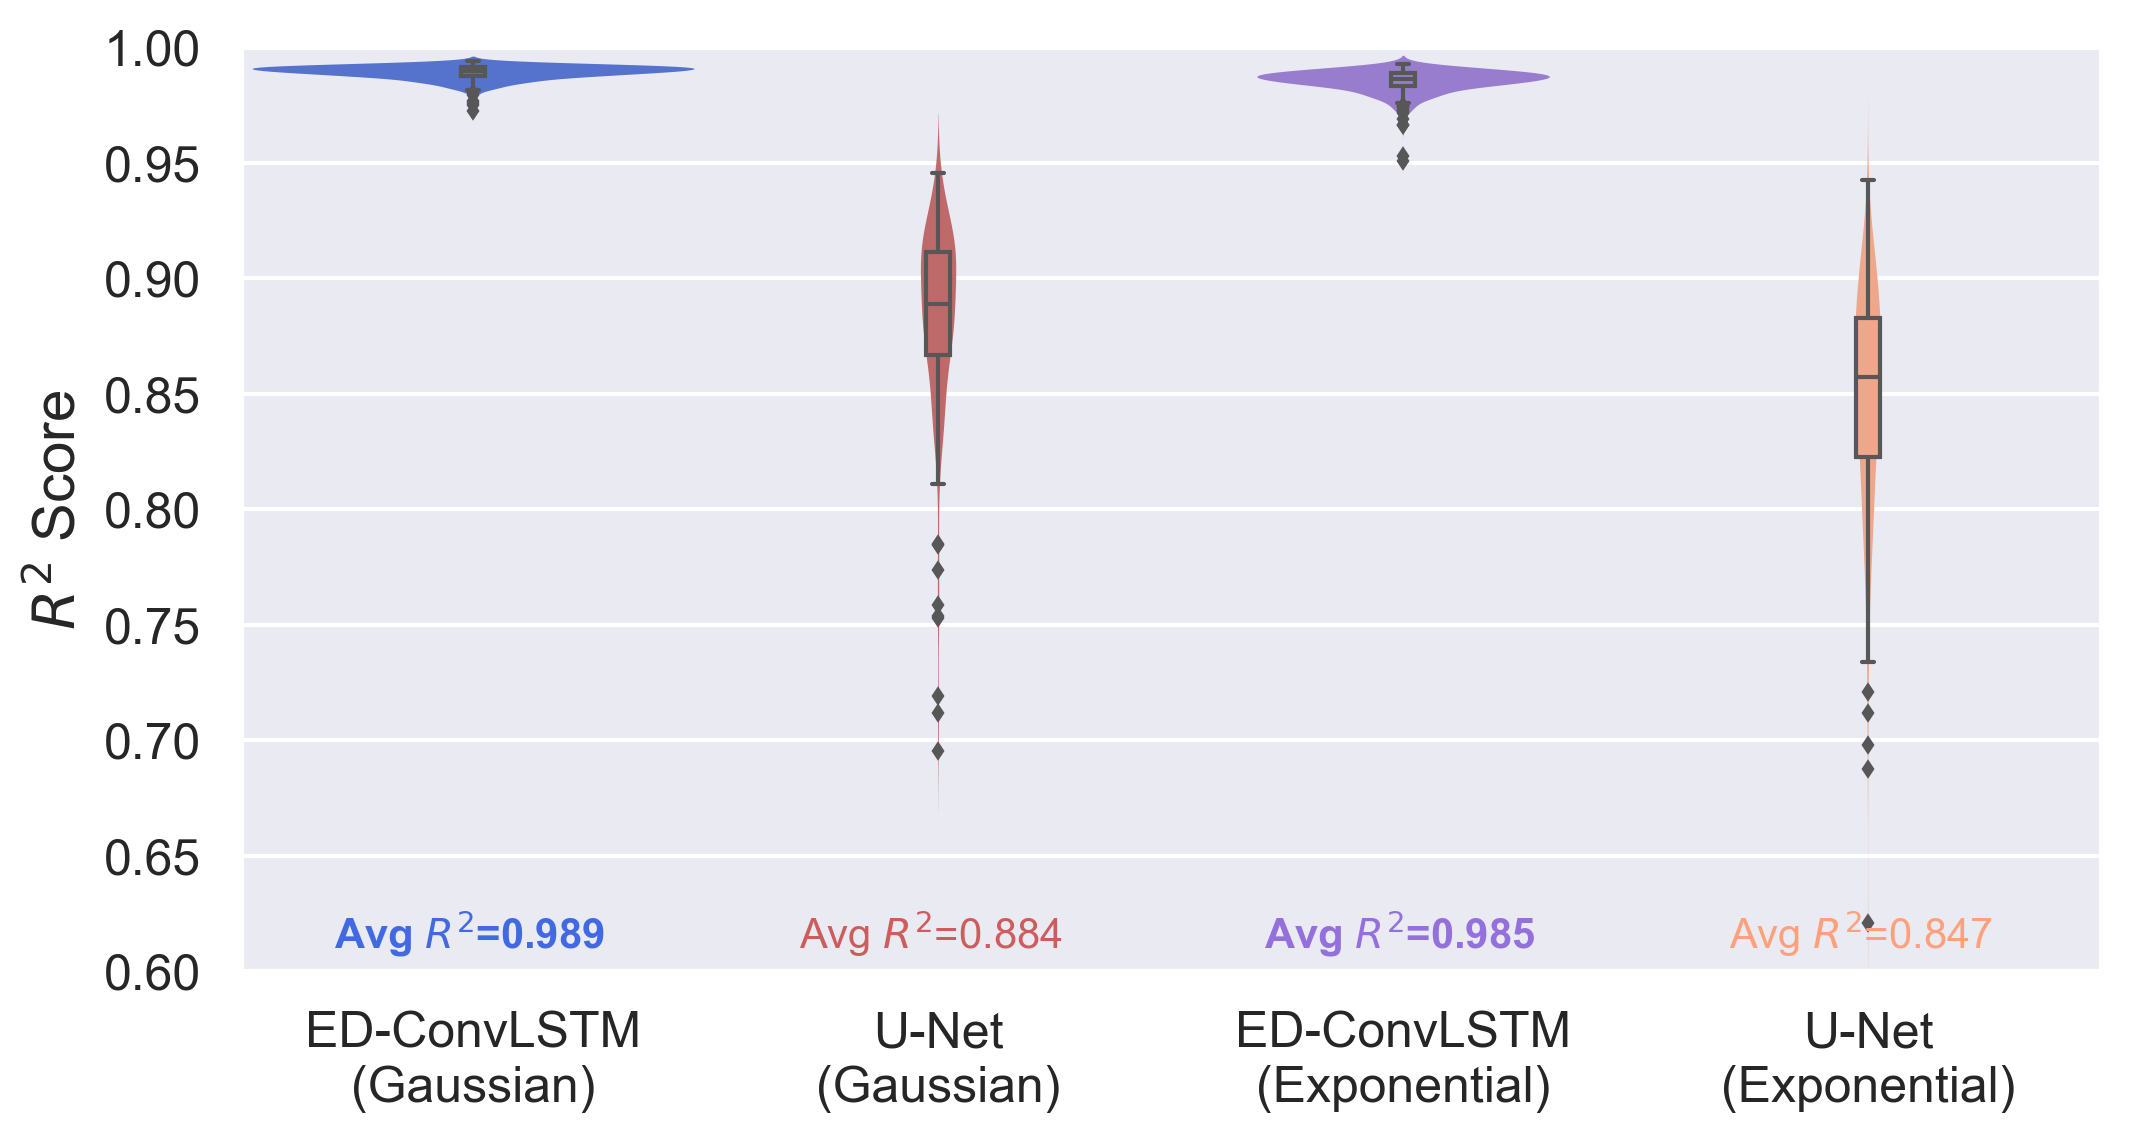

In [53]:
violin_data = np.stack((lstm_sample_r2, u_sample_r2, lstm_sample_r2_geo, u_sample_r2_geo), axis=1)
print(violin_data.shape)

import seaborn as sns
sns.set(style = 'darkgrid')

plt.figure(figsize=(8,4), dpi=300)
ax=plt.gca()
colors = ['royalblue', 'indianred', 'mediumpurple', 'lightsalmon']

sns.violinplot(
    data=violin_data,
    inner='point',
    ax=ax,
    linewidth=0.0,
    palette=colors,
    density_norm='area',
    width=0.95

)
sns.boxplot(
    data=violin_data,
    width=0.05,
    ax=ax,
    boxprops={'zorder': 2},
    palette=colors,
    linewidth=1.0,
    fliersize=2,
)

ax.text(0.6-0.9, 0.61, F'Avg $R^2$={np.mean(lstm_sample_r2):.3f}', fontsize=10, c=colors[0], alpha=1.0, fontweight='semibold')
ax.text(1.6-0.9, 0.61, F'Avg $R^2$={np.mean(u_sample_r2):.3f}', fontsize=10, c=colors[1], alpha=1.0)
ax.text(2.6-0.9, 0.61, F'Avg $R^2$={np.mean(lstm_sample_r2_geo):.3f}', fontsize=10, c=colors[2], alpha=1.0, fontweight='semibold')
ax.text(3.6-0.9, 0.61, F'Avg $R^2$={np.mean(u_sample_r2_geo):.3f}', fontsize=10, c=colors[3], alpha=1.0)

# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.10))
ax.set_ylim(0.6, 1)
ax.set_xticks([0, 1, 2, 3], labels=['ED-ConvLSTM\n(Gaussian)', 'U-Net\n(Gaussian)', 'ED-ConvLSTM\n(Exponential)', 'U-Net\n(Exponential)'], fontsize=12)
ax.tick_params(axis="y", labelsize=12)
plt.ylabel('$R^2$ Score', fontsize=14)
plt.savefig('chutu\\violin_pre_extra.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [22]:
unet_s = UNET(in_channels=4, out_channels=1).float().to(device)
unet_s.load_state_dict(torch.load('Unet_model_weights_10.12_s.pth', map_location=device))
unet_s.eval()
convlstm_s = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
convlstm_s.load_state_dict(torch.load(f'model_weights_10.30-15.28_s@84.pth', map_location=device))    # [notice] match !!
convlstm_s.eval()
print('done')

def rmse_lstm_s(case_num):
    min_v = 0
    max_v = 0.87943658597

    with torch.no_grad():
        x = torch.load(f'tttt_train_s_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm_s(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        # y_arr = y_arr / 1e6

    true = torch.load(f'tttt_train_s_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
#     true = true / 1e6

    rmse_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


def rmse_u_s(case_num):
    min_v = 0
    max_v = 0.87943658597

    y_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'ttt_Unet_train_s_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet_s(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            # y_arr = y_arr / 1e6
            y_list.append(y_arr)
    y_list = np.stack(y_list, axis=0)

    true_list = []
    for tt in range(60):
        true = torch.load(f'ttt_Unet_train_s_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
#         true = true / 1e6
        true_list.append(true)
    true_list = np.stack(true_list, axis=0)

    rmse_list = []
    for ii in range(60):
        y_tmp = y_list[ii, :, :]
        true_tmp = true_list[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list

def rmse_lstm_s_geo(case_num):
    min_v = 0
    max_v = 0.87943658597

    with torch.no_grad():
        x = torch.load(f'geo_train_s_x\\{case_num:>04}.pt').to(device).squeeze()
        y, _ = convlstm_s(x.float().unsqueeze(0), )
        y_arr = y.squeeze().detach().cpu().numpy()    # [60, 64, 64]
        y_arr = y_arr * (max_v - min_v) + min_v
        # y_arr = y_arr / 1e6

    true = torch.load(f'geo_train_s_y\\{case_num:>04}.pt').squeeze().numpy()    # [60, 64, 64]
    true = true * (max_v - min_v) + min_v
#     true = true / 1e6

    rmse_list = []
    for ii in range(60):
        y_tmp = y_arr[ii, :, :]
        true_tmp = true[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


def rmse_u_s_geo(case_num):
    min_v = 0
    max_v = 0.87943658597

    y_list = []
    for ts in range(60):
        with torch.no_grad():
            x = torch.load(f'geo_Unet_train_s_x\\{case_num:>04}_{ts}.pt').to(device).squeeze()
            y = unet_s(x.float().unsqueeze(0))
            y_arr = y.squeeze().detach().cpu().numpy()    # [64, 64]
            y_arr = y_arr * (max_v - min_v) + min_v
            # y_arr = y_arr / 1e6
            y_list.append(y_arr)
    y_list = np.stack(y_list, axis=0)

    true_list = []
    for tt in range(60):
        true = torch.load(f'geo_Unet_train_s_y\\{case_num:>04}_{tt}.pt').squeeze().numpy()    # [64, 64]
        true = true * (max_v - min_v) + min_v
#         true = true / 1e6
        true_list.append(true)
    true_list = np.stack(true_list, axis=0)

    rmse_list = []
    for ii in range(60):
        y_tmp = y_list[ii, :, :]
        true_tmp = true_list[ii, :, :]
        rmse_v = r2_score(true_tmp.flatten(), y_tmp.flatten())
        rmse_list.append(rmse_v)
    return rmse_list


rmse_lstm_whole_s = []
rmse_u_whole_s = []
for cc in np.arange(5000, 5250):
    lstm__s = rmse_lstm_s(cc)
    u__s = rmse_u_s(cc)
    rmse_lstm_whole_s.append(lstm__s)
    rmse_u_whole_s.append(u__s)
rmse_lstm_whole_s = np.stack(rmse_lstm_whole_s, axis=0)
rmse_u_whole_s = np.stack(rmse_u_whole_s, axis=0)
print(rmse_lstm_whole_s.shape, rmse_u_whole_s.shape)

rmse_lstm_whole_s_geo = []
rmse_u_whole_s_geo = []
for gg in np.arange(8000, 8250):
    lstm_geo_s = rmse_lstm_s_geo(gg)
    u_geo_s = rmse_u_s_geo(gg)
    rmse_lstm_whole_s_geo.append(lstm_geo_s)
    rmse_u_whole_s_geo.append(u_geo_s)
rmse_lstm_whole_s_geo = np.stack(rmse_lstm_whole_s_geo, axis=0)
rmse_u_whole_s_geo = np.stack(rmse_u_whole_s_geo, axis=0)
print(rmse_lstm_whole_s_geo.shape, rmse_u_whole_s_geo.shape)

done
(250, 60) (250, 60)
(250, 60) (250, 60)


In [23]:
lstm_sample_r2_s = np.mean(rmse_lstm_whole_s, axis=1)
u_sample_r2_s = np.mean(rmse_u_whole_s, axis=1)
print(lstm_sample_r2_s.shape, u_sample_r2_s.shape)

lstm_sample_r2_s_geo = np.mean(rmse_lstm_whole_s_geo, axis=1)
u_sample_r2_s_geo = np.mean(rmse_u_whole_s_geo, axis=1)
print(lstm_sample_r2_s_geo.shape, u_sample_r2_s_geo.shape)

(250,) (250,)
(250,) (250,)


(250, 4)


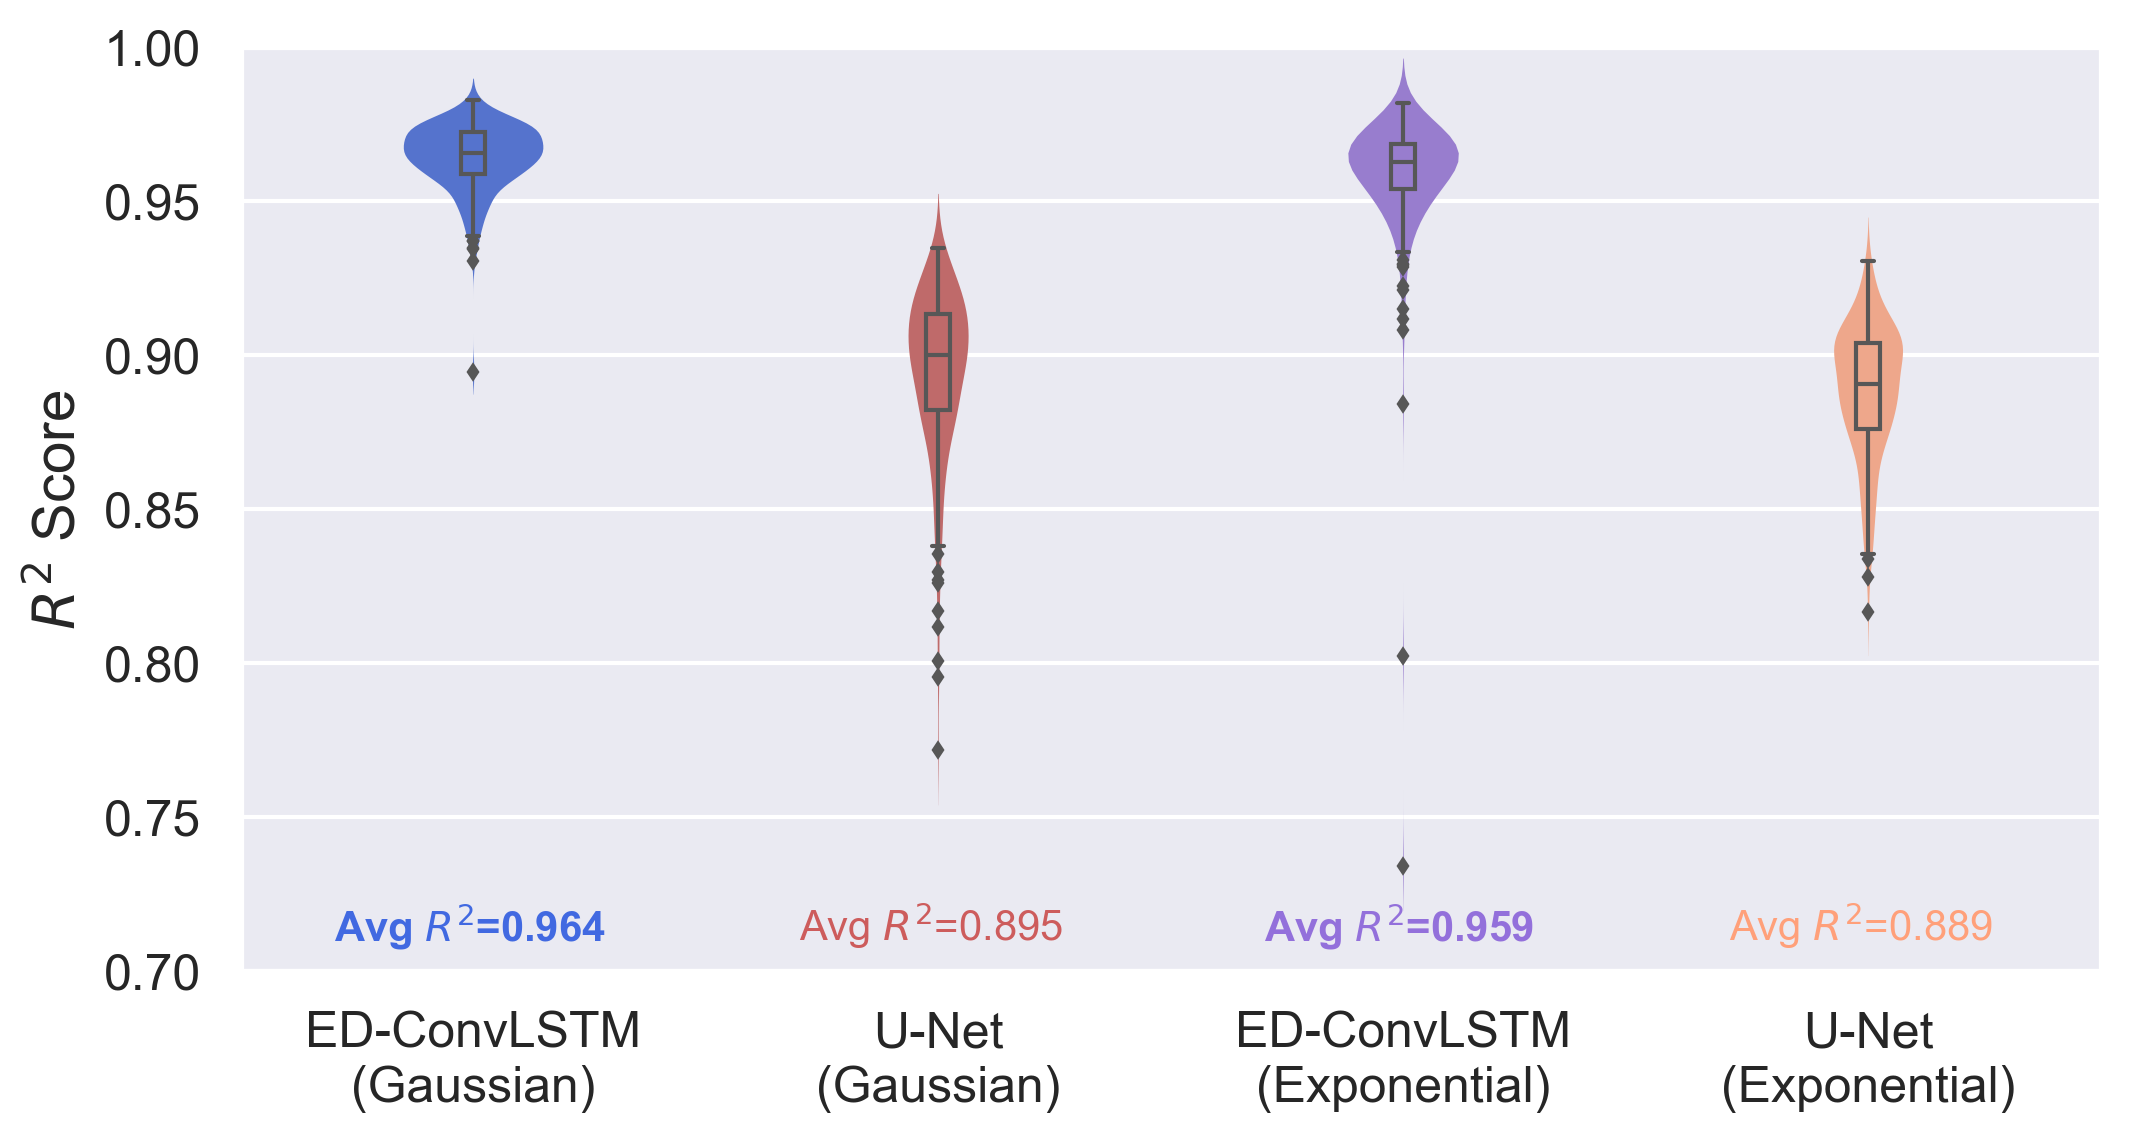

In [54]:
violin_data_s = np.stack((lstm_sample_r2_s, u_sample_r2_s, lstm_sample_r2_s_geo, u_sample_r2_s_geo), axis=1)
print(violin_data_s.shape)

import seaborn as sns
sns.set(style = 'darkgrid')

plt.figure(figsize=(8,4), dpi=300)
ax=plt.gca()
colors = ['royalblue', 'indianred', 'mediumpurple', 'lightsalmon']

sns.violinplot(
    data=violin_data_s,
    inner='point',
    ax=ax,
    linewidth=0.0,
    palette=colors,
    density_norm='area',
    width=0.3
    
    
    
)
sns.boxplot(
    data=violin_data_s,
    width=0.05,
    ax=ax,
    boxprops={'zorder': 2},
    palette=colors,
    linewidth=1.0,
    fliersize=2,



)

ax.text(0.6-0.9, 0.71, F'Avg $R^2$={np.mean(lstm_sample_r2_s):.3f}', fontsize=10, c=colors[0], alpha=1.0, fontweight='semibold')
ax.text(1.6-0.9, 0.71, F'Avg $R^2$={np.mean(u_sample_r2_s):.3f}', fontsize=10, c=colors[1], alpha=1.0)
ax.text(2.6-0.9, 0.71, F'Avg $R^2$={np.mean(lstm_sample_r2_s_geo):.3f}', fontsize=10, c=colors[2], alpha=1.0, fontweight='semibold')
ax.text(3.6-0.9, 0.71, F'Avg $R^2$={np.mean(u_sample_r2_s_geo):.3f}', fontsize=10, c=colors[3], alpha=1.0)

# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.10))
ax.set_ylim(0.7, 1)
ax.set_xticks([0, 1, 2, 3], labels=['ED-ConvLSTM\n(Gaussian)', 'U-Net\n(Gaussian)', 'ED-ConvLSTM\n(Exponential)', 'U-Net\n(Exponential)'], fontsize=12)
ax.tick_params(axis="y", labelsize=12)
plt.ylabel('$R^2$ Score', fontsize=14)
plt.savefig('chutu\\violin_sat_extra.tiff', dpi=1000, bbox_inches='tight', pad_inches=0.1)

(250, 8)


<Axes: >

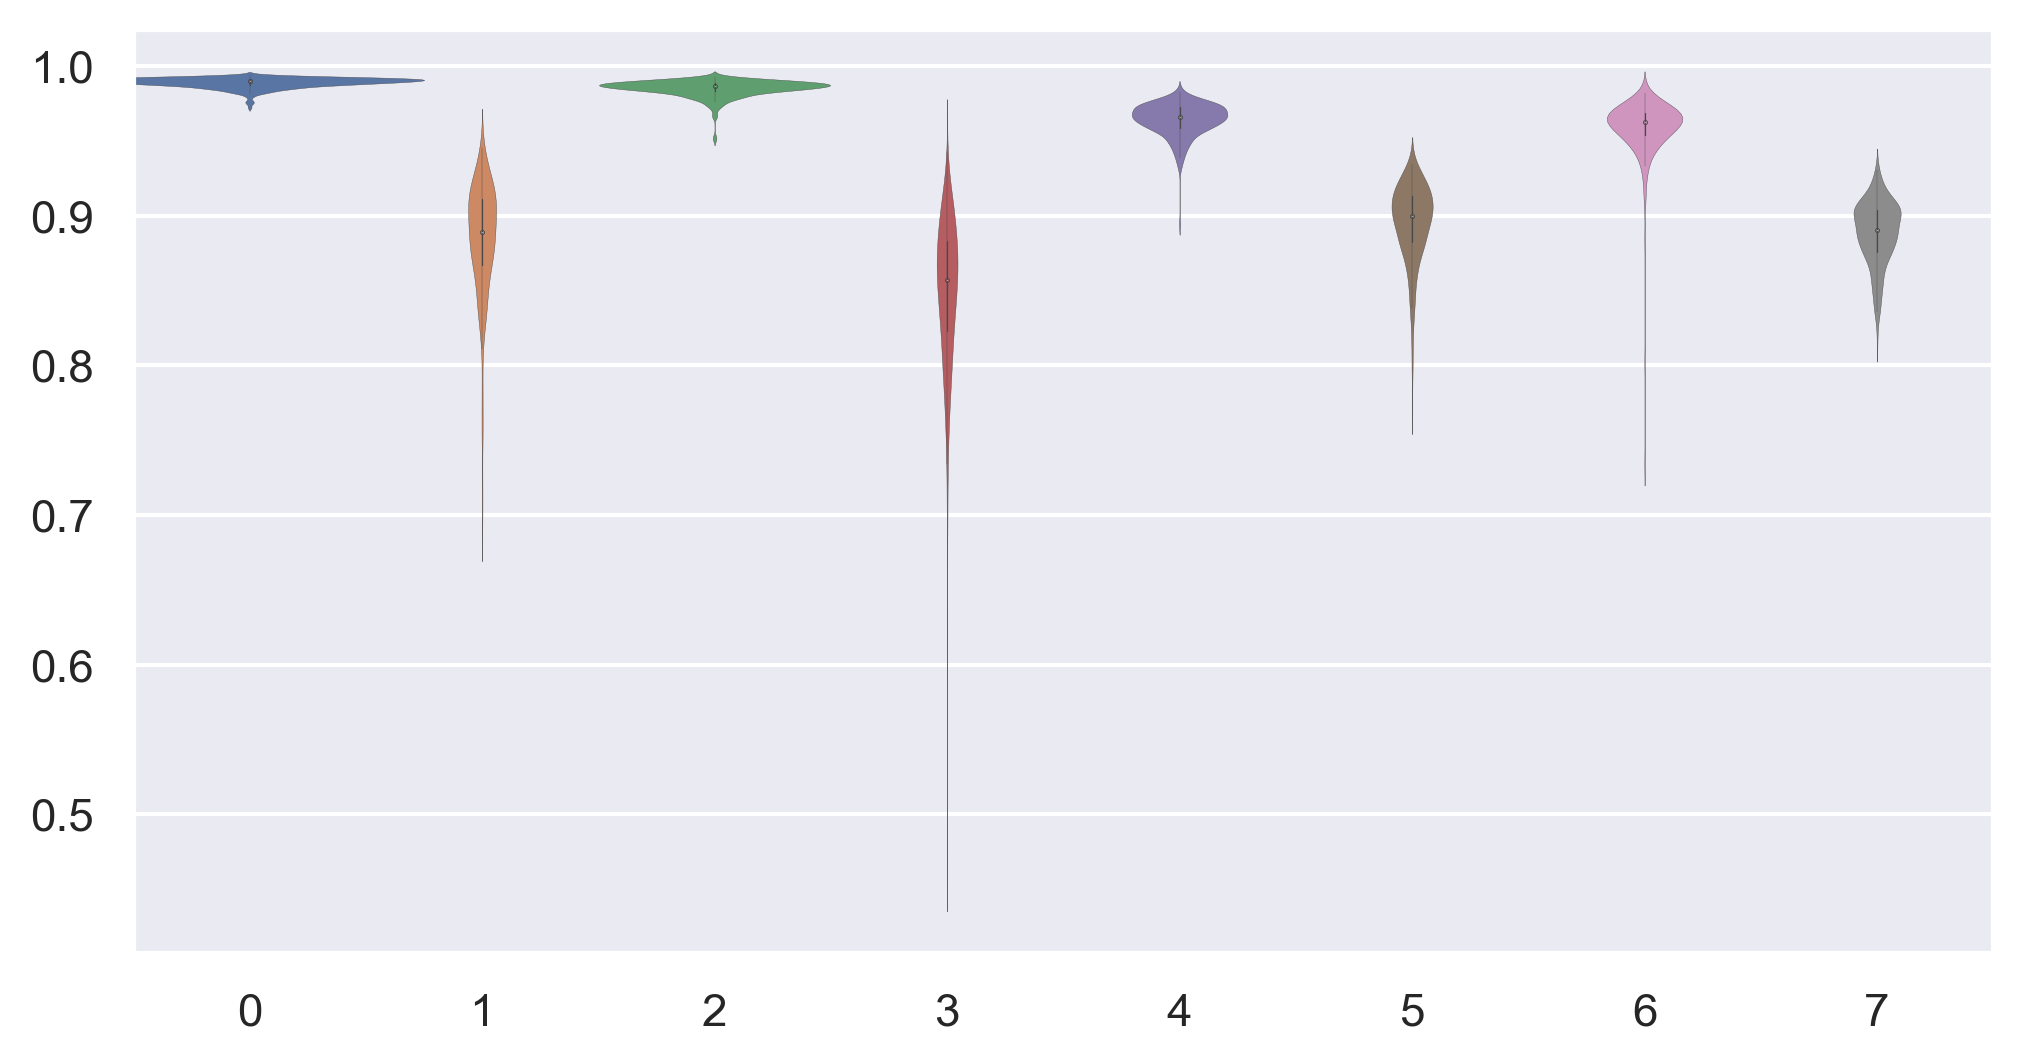

In [45]:
aa = np.stack((lstm_sample_r2, u_sample_r2, lstm_sample_r2_geo, u_sample_r2_geo, lstm_sample_r2_s, u_sample_r2_s, lstm_sample_r2_s_geo, u_sample_r2_s_geo), axis=1)
print(aa.shape)
plt.figure(figsize=(8,4), dpi=300)
sns.violinplot(
    data=aa,
    linewidth=0.1,
    density_norm='width',
    width=1.5,
)